In [1]:
'''
统一设置地址
'''

import os

# 获取当前工作目录
current_dir = os.getcwd()
print("当前工作目录：", current_dir)

# 修改当前工作目录，以后输出文件只需要写文件名
new_dir = r'D:/BaiduSyncdisk/新建文件夹/桌面文件/深度学习程序/A_轮廓线识别/多分类文件/'
os.chdir(new_dir)
print("修改后的工作目录：", os.getcwd())

当前工作目录： C:\Users\51625
修改后的工作目录： D:\BaiduSyncdisk\新建文件夹\桌面文件\深度学习程序\A_轮廓线识别\多分类文件


In [19]:
import numpy as np
import tensorflow as tf
import networkx as nx
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.utils import register_keras_serializable

In [11]:
'''加载模型'''
model_load_path = r'Sept30/pointnet2_segmentation_model_2.keras'

file_path = r'D:\BaiduSyncdisk\新建文件夹\桌面文件\深度学习程序\A_轮廓线识别\重新处理后的数据_手工筛选_0727\肩台外侧点_0715\150颗\17.obj' # 替换为实际的 OBJ 文件路径
#file_path = r'D:\BaiduSyncdisk\新建文件夹\桌面文件\深度学习程序\A_轮廓线识别\重新处理后的数据_手工筛选_0727\肩台外侧点_0715\77\77_3.obj'

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

@register_keras_serializable(package="Custom")
class SamplingLayer(tf.keras.layers.Layer):
    def __init__(self, N_prime=None, **kwargs):
        super(SamplingLayer, self).__init__(**kwargs)
        self.N_prime = N_prime

    def call(self, points):
        if self.N_prime is None:
            return points, tf.range(tf.shape(points)[1])  # 不采样，直接返回原始输入点和索引
        
        B = tf.shape(points)[0]  # 获取批次大小
        N = tf.shape(points)[1]  # 获取点的数量
        C = tf.shape(points)[2]  # 获取每个点的特征维度

        sampled_points_batch = tf.TensorArray(dtype=points.dtype, size=B)
        sampled_indices_batch = tf.TensorArray(dtype=tf.int32, size=B)

        def sample_one_batch(b):
            distances = tf.ones((N,), dtype=tf.float32) * 1e10

            first_point_index = tf.random.uniform(shape=[], minval=0, maxval=N, dtype=tf.int32)
            sampled_points = tf.TensorArray(dtype=points.dtype, size=self.N_prime)
            sampled_indices = tf.TensorArray(dtype=tf.int32, size=self.N_prime)
            sampled_points = sampled_points.write(0, tf.gather(points[b], first_point_index))
            sampled_indices = sampled_indices.write(0, first_point_index)

            distances = tf.norm(points[b, :, :3] - points[b, first_point_index, :3], axis=-1)

            def body(i, sampled_points, sampled_indices, distances):
                farthest_point_index = tf.argmax(distances)
                farthest_point_index = tf.cast(farthest_point_index, tf.int32)

                farthest_point = tf.gather(points[b], farthest_point_index)
                sampled_points = sampled_points.write(i, farthest_point)
                sampled_indices = sampled_indices.write(i, farthest_point_index)
                distances = tf.minimum(distances, tf.norm(points[b, :, :3] - farthest_point[:3], axis=-1))
                return i + 1, sampled_points, sampled_indices, distances

            i = tf.constant(1)
            _, sampled_points, sampled_indices, _ = tf.while_loop(
                lambda i, *_: i < self.N_prime,
                body,
                loop_vars=[i, sampled_points, sampled_indices, distances]
            )

            return sampled_points.stack(), sampled_indices.stack()

        # 使用 tf.map_fn 处理每个批次中的点云数据
        sampled_points_batch, sampled_indices_batch = tf.map_fn(
            sample_one_batch,
            tf.range(B),
            fn_output_signature=(tf.float32, tf.int32),
            parallel_iterations=10
        )

        return sampled_points_batch, sampled_indices_batch


#调试确保sampled_points的类型和内容是对的
def call(self, sampled_points, points):
    print("sampled_points:", sampled_points)
    print("points:", points)
    sampled_points_tensor, sampled_indices = sampled_points
    # 然后继续进行其他操作

class GroupingLayer(tf.keras.layers.Layer):
    def __init__(self, R, K, **kwargs):
        super(GroupingLayer, self).__init__(**kwargs)
        self.R = R
        self.K = K

    @tf.function
    def call(self, sampled_points_tensor, sampled_indices, points):
        B = tf.shape(points)[0]      # 批次大小
        N_prime = tf.shape(sampled_points_tensor)[1]  # 采样点的数量

        # 计算采样点和所有点之间的距离
        distances = tf.norm(
            tf.expand_dims(points[:, :, :3], axis=1) - tf.expand_dims(sampled_points_tensor[:, :, :3], axis=2),
            axis=-1
        )

        # 选取距离最近的 K 个点
        _, top_k_indices = tf.nn.top_k(-distances, k=self.K)

        # 构建批次索引
        batch_indices = tf.tile(
            tf.reshape(tf.range(B), (B, 1, 1)), [1, N_prime, self.K]
        )

        # 构建正确的 gather_nd 索引，包含批次索引和点索引
        gather_indices = tf.stack([batch_indices, top_k_indices], axis=-1)

        # 使用 gather_nd 提取 K 个最接近的点
        grouped_points = tf.gather_nd(points, gather_indices)

        return grouped_points

@register_keras_serializable(package="Custom")
class PointNetLayer(tf.keras.layers.Layer):
    def __init__(self, conv_layers, **kwargs):
        super(PointNetLayer, self).__init__(**kwargs)
        self.conv_layers = conv_layers

    def call(self, local_regions):
        B, N_prime, K, D = tf.unstack(tf.shape(local_regions))
        
        # 计算局部坐标，即令每个局部区域的所有点的坐标减掉该区域的球心坐标
        center_point = local_regions[:, :, 0, :3]  # Shape: (B, N', 3)
        local_coords = local_regions[:, :, :, :3] - tf.expand_dims(center_point, axis=2)
        
        # 把局部坐标（前3个特征维度）和特征（后续特征维度）拼接到一起
        reshape_points = tf.concat([local_coords, local_regions[:, :, :, 3:]], axis=-1)
        
        # 将局部区域点云变形为 (B, N', K * D) 的形状，并转换为 float32 类型，便于进行卷积运算
        reshape_points = tf.reshape(reshape_points, (B, N_prime, K * D))
        reshape_points = tf.cast(reshape_points, dtype=tf.float32)

        new_points = reshape_points
        for layer in self.conv_layers:
            new_points = layer(new_points)
        
        new_points = tf.concat([center_point, new_points], axis=-1)
        
        return new_points

#简化SA模块
# 定义完整SA模块

    '''
    完整的Set Abstraction模块，由Sampling层、Grouping层、PointNet层串联组成。
    '''
@register_keras_serializable(package="Custom")    
class SAModule(tf.keras.layers.Layer):
    def __init__(self, sampling_layer, grouping_layer, pointnet_layer, **kwargs):
        super(SAModule, self).__init__(**kwargs)
        self.sampling_layer = sampling_layer
        self.grouping_layer = grouping_layer
        self.pointnet_layer = pointnet_layer

    def call(self, xyz, points):
        # 下采样和分组
        sampled_points_tensor, sampled_indices = self.sampling_layer(xyz)
        grouped_points = self.grouping_layer(sampled_points_tensor, sampled_indices, xyz)  # 传递采样点和原始点
        new_points = self.pointnet_layer(grouped_points)
        return sampled_points_tensor, new_points  # 返回采样后的点和提取的新特征

@register_keras_serializable(package="Custom")

class PointNetFeaturePropagation(tf.keras.layers.Layer):
    def __init__(self, mlp_layers, k=8, use_batchnorm=True,  **kwargs):
        super(PointNetFeaturePropagation, self).__init__(**kwargs)
        self.k = k  # 最近邻点的数量
        self.use_batchnorm = use_batchnorm
    
        self.mlp_layers = []
        
        # 根据参数添加 MLP 层，并选择是否添加 Batch Normalization 和 Dropout
        for units in mlp_layers:
            self.mlp_layers.append(layers.Conv1D(units, 1, activation=None))
            if self.use_batchnorm:
                self.mlp_layers.append(layers.BatchNormalization())
            self.mlp_layers.append(layers.ReLU())
            

    def call(self, xyz1, xyz2, points1, points2):
        """
        Inputs:
            xyz1: 上采样后的点云坐标, [B, N1, C]
            xyz2: 下采样后的点云坐标, [B, N2, C]
            points1: 上采样后的点云特征, [B, N1, D1]
            points2: 下采样后的点云特征, [B, N2, D2]
        Returns:
            new_points: 上采样后的点云特征, [B, N1, D_out]
        """
        # 最近邻插值
        interpolated_points = self.interpolate(xyz1, xyz2, points2)

        # 跳跃连接：拼接插值后的特征与上采样后的特征
        if points1 is not None:
            new_points = tf.concat([points1, interpolated_points], axis=-1)
        else:
            new_points = interpolated_points

        # 通过 MLP 处理拼接后的特征
        for layer in self.mlp_layers:
            new_points = layer(new_points)
        
        return new_points

    def interpolate(self, xyz1, xyz2, points2):
        """
        插值操作：根据 xyz1 的坐标找到 xyz2 中最近的点，并对 points2 的特征进行插值。
        """
        # 计算 xyz1 和 xyz2 之间的平方距离
        dists = square_distance(xyz1, xyz2)
        dists, idx = tf.nn.top_k(-dists, k=self.k)  # 选择 k 个最近邻
        dists = -dists

        # 避免距离为零
        dists = tf.maximum(dists, 1e-10)

        # 使用高斯函数计算权重
        sigma = 0.5  # 标准差，需要根据数据集调整
        weight = tf.exp(-dists / (2 * sigma ** 2))
        weight_sum = tf.reduce_sum(weight, axis=-1, keepdims=True)
        weight = weight / weight_sum

        # 获取对应的点的特征
        interpolated_points = index_points(points2, idx)  # [B, N1, k, D]
        
        # 使用插值权重对 points2 的特征进行加权求和
        interpolated_points = tf.reduce_sum(interpolated_points * tf.expand_dims(weight, -1), axis=2)  # [B, N1, D]
        return interpolated_points


def square_distance(src, dst):
    """
    计算点云之间的平方距离
    :param src: [B, N1, C]
    :param dst: [B, N2, C]
    :return: [B, N1, N2] 每个点与其他点的距离
    """
    diff = tf.expand_dims(src, axis=2) - tf.expand_dims(dst, axis=1)
    return tf.reduce_sum(tf.square(diff), axis=-1)

def index_points(points, idx):
    """
    根据给定的索引从 points 中提取点
    :param points: [B, N2, D2]
    :param idx: [B, N1, K]
    :return: [B, N1, K, D2]
    """
    batch_size = tf.shape(points)[0]
    batch_indices = tf.range(batch_size)[:, tf.newaxis, tf.newaxis, tf.newaxis]
    batch_indices = tf.tile(batch_indices, [1, tf.shape(idx)[1], tf.shape(idx)[2], 1])

    full_idx = tf.concat([batch_indices, idx[..., tf.newaxis]], axis=-1)
    gathered_points = tf.gather_nd(points, full_idx)
    return gathered_points


@register_keras_serializable(package="Custom")
class PointNetPlusPlus(tf.keras.Model):
    def __init__(self, num_classes, **kwargs):
        super(PointNetPlusPlus, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.l2_reg = 0.0001

        # SA and FP layers
        self.sa1 = SAModule(
            SamplingLayer(N_prime=1024),
            GroupingLayer(R=0.2, K=32),
            PointNetLayer(conv_layers=[
                layers.Conv1D(64, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg)),
                layers.Conv1D(64, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg)),
                layers.Conv1D(128, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg))
            ])
        )
        self.sa2 = SAModule(
            SamplingLayer(N_prime=256),
            GroupingLayer(R=0.4, K=32),
            PointNetLayer(conv_layers=[
                layers.Conv1D(128, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg)),
                layers.Conv1D(128, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg)),
                layers.Conv1D(256, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg))
            ])
        )
        self.sa3 = SAModule(
            SamplingLayer(N_prime=64),
            GroupingLayer(R=0.8, K=32),
            PointNetLayer(conv_layers=[
                layers.Conv1D(256, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg)),
                layers.Conv1D(256, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg)),
                layers.Conv1D(512, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg))
            ])
        )
        self.sa4 = SAModule(
            SamplingLayer(N_prime=16),
            GroupingLayer(R=1, K=32),
            PointNetLayer(conv_layers=[
                layers.Conv1D(512, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg)),
                layers.Conv1D(512, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg)),
                layers.Conv1D(1024, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg))
            ])
        )

        # Feature Propagation layers
        self.fp4 = PointNetFeaturePropagation([512, 512])
        self.fp3 = PointNetFeaturePropagation([256, 256])
        self.fp2 = PointNetFeaturePropagation([256, 128])
        self.fp1 = PointNetFeaturePropagation([128, 128, 128])

        self.conv1 = layers.Conv1D(128, 1)
        self.bn1 = layers.BatchNormalization()
        self.drop1 = layers.Dropout(0.5)
        self.conv2 = layers.Conv1D(num_classes, 1)
        
        self.input_shape_ = None  # 初始化 input_shape_ 属性

    def call(self, inputs):
        if self.input_shape_ is None:
            self.input_shape_ = inputs.shape[1:]  # 动态获取输入的形状，排除 batch 维度

        # 提取点的3D坐标 (xyz)，假设输入数据的前三个维度是坐标
        l0_xyz = inputs[:, :, :3]  # 只保留坐标部分
        l0_points = inputs  # 所有输入点的特征

        # Set Abstraction 层
        l1_xyz, l1_points = self.sa1(l0_xyz, l0_points)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)
        l4_xyz, l4_points = self.sa4(l3_xyz, l3_points)

        # Feature Propagation 层
        l3_points = self.fp4(l3_xyz, l4_xyz, l3_points, l4_points)  # 使用 3D 坐标
        l2_points = self.fp3(l2_xyz, l3_xyz, l2_points, l3_points)
        l1_points = self.fp2(l1_xyz, l2_xyz, l1_points, l2_points)
        l0_points = self.fp1(l0_xyz, l1_xyz, None, l1_points)

        # 最终分类
        x = tf.nn.relu(self.bn1(self.conv1(l0_points)))
        x = self.drop1(x)  # Dropout 在激活之后
        logits = self.conv2(x)
        logits = tf.nn.log_softmax(logits, axis=-1)  # 计算每个点的类别概率分布
        
        return logits
    
    def get_config(self):
        config = super(PointNetPlusPlus, self).get_config()
        config.update({
            'num_classes': self.num_classes,
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(num_classes=config['num_classes'])

In [13]:

import tensorflow as tf

# 注册自定义损失函数
@tf.keras.saving.register_keras_serializable(package="Custom")
def custom_loss_with_iou_and_class_weights(y_true, y_pred, num_classes, class_weights):
    # 将类别权重转换为张量
    class_weights_tensor = tf.convert_to_tensor(class_weights, dtype=tf.float32)

    # 交叉熵损失 (带类别权重)
    cross_entropy_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
    sample_weights = tf.gather(class_weights_tensor, y_true)  # 根据y_true获取相应类别的权重
    cross_entropy_loss = tf.reduce_mean(cross_entropy_loss * sample_weights)  # 加权交叉熵损失

    # 获取预测类别
    y_pred_classes = tf.argmax(y_pred, axis=-1)

    # 计算IoU
    iou_list, mean_iou = compute_iou(y_true, y_pred_classes, num_classes)

    # 使用IoU调整损失权重
    iou_weight = 1 - mean_iou  # IoU越大，权重越小

    # 返回结合IoU和类别权重调整后的损失
    total_loss = cross_entropy_loss * iou_weight

    return total_loss

# 注册包装函数，将 Keras 的损失函数与类别数和类别权重绑定
@tf.keras.saving.register_keras_serializable(package="Custom")
def loss_fn(y_true, y_pred):
    num_classes = 9  # 设置类别数量
    class_weights = [0.0001, 0.5, 5, 4, 4, 6.7, 2, 2, 2]  # 设置类别权重
    return custom_loss_with_iou_and_class_weights(y_true, y_pred, num_classes, class_weights)


In [14]:

# 自定义损失函数字典
custom_objects = {
    'PointNetPlusPlus': PointNetPlusPlus,
    'loss_fn': loss_fn, 
    'custom_loss_with_iou_and_class_weights': custom_loss_with_iou_and_class_weights
}

try:
    model = tf.keras.models.load_model(model_load_path, custom_objects=custom_objects,safe_mode=False)
    print("模型加载成功！")
except Exception as e:
    print("模型加载失败:", e)

模型加载成功！


Unique labels in test set: [1 2 3 4 5 6 7 8]
Test labels shape: (80, 4096)
Test labels min: 1 Test labels max: 8
3/3 [==============================] - 11s 3s/step
Test labels shape: (80, 4096)
Predicted classes shape: (80, 4096)


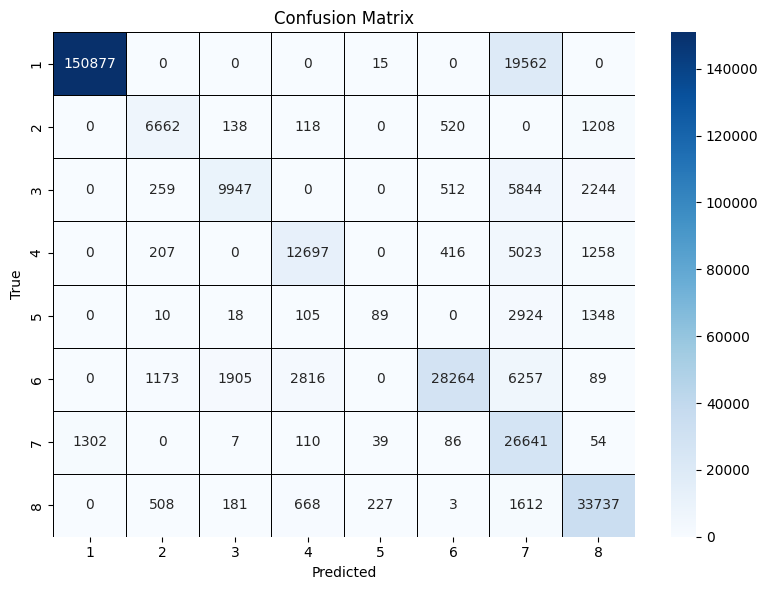

In [8]:
'''
混淆矩阵 测试集
'''
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 加载测试集数据
def load_npz_dataset(npz_file):
    data = np.load(npz_file)
    points = data['points']  # shape: [num_samples, num_points, 3]
    labels = data['labels']  # shape: [num_samples, num_points]
    
    # 检查标签的唯一值和范围
    print("Unique labels in test set:", np.unique(labels))
    print("Test labels shape:", labels.shape)
    print("Test labels min:", np.min(labels), "Test labels max:", np.max(labels))
    
    return points, labels

# 2.加载测试集
test_points, test_labels = load_npz_dataset("Sept30/test_dataset.npz")

# 3. 使用模型进行预测
y_pred = model.predict(test_points)  # y_pred shape: [num_samples, num_points, num_classes]

# 4.如果模型输出的是概率分布，需要将其转换为类别索引
y_pred_classes = np.argmax(y_pred, axis=-1)  # shape: [num_samples, num_points]

# 5. 展平标签和预测结果前，检查形状是否一致
print("Test labels shape:", test_labels.shape)  # Expected: [num_samples, num_points]
print("Predicted classes shape:", y_pred_classes.shape)  # Expected: [num_samples, num_points]

# 6. 展平标签和预测结果
y_test = test_labels.flatten()  # shape: [num_samples * num_points]
y_pred_classes_flat = y_pred_classes.flatten()  # shape: [num_samples * num_points]

# 7. 检查展平后的形状是否一致
assert y_test.shape == y_pred_classes_flat.shape,"Shape mismatch between true labels and predictions!" 

# 8. 生成混淆矩阵并可视化

cm = confusion_matrix(y_test, y_pred_classes_flat, labels=[1, 2, 3, 4, 5, 6, 7, 8])

# 绘制混淆矩阵的热力图
plt.figure(figsize=(8, 6))  # 调整图表尺寸
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=[1, 2, 3, 4, 5, 6, 7, 8], 
            yticklabels=[1, 2, 3, 4, 5, 6, 7, 8], 
            linewidths=0.5, linecolor='black', vmin=0, vmax=cm.max())  # 调整vmin和vmax增加对比度

# 添加标签和标题
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# 显示图表
plt.tight_layout()
plt.show()

使用了 1 轮插值来让点云点数满足要求
1/1 [==============================] - 2s 2s/step
Predictions shape: (1, 4096, 9)
Predicted labels: [6 1 7 ... 1 1 1]
类别 1: 2182 次，占 53.27%
类别 2: 88 次，占 2.15%
类别 3: 297 次，占 7.25%
类别 4: 306 次，占 7.47%
类别 5: 89 次，占 2.17%
类别 6: 491 次，占 11.99%
类别 7: 250 次，占 6.10%
类别 8: 393 次，占 9.59%
最大类别为: 8


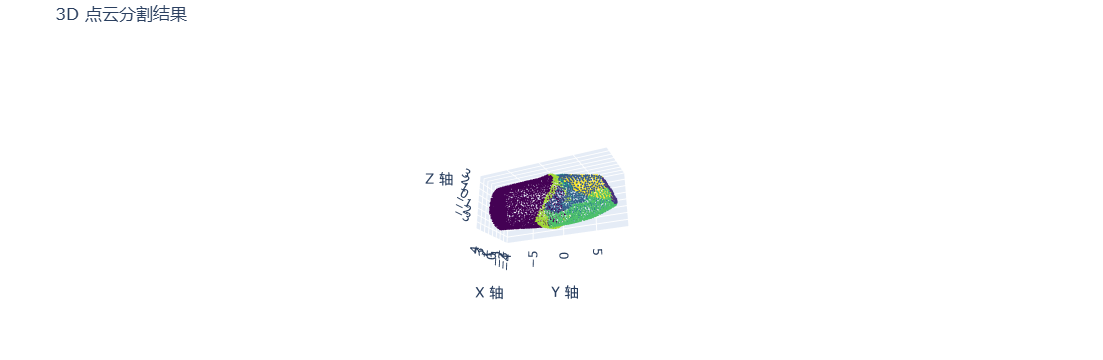

In [15]:
'''
OPEN 3D 预测结果初步可视化  最远点采样
'''
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import plotly.graph_objects as go
import open3d as o3d



def load_obj_file(file_path):
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return np.array(vertices), np.array(faces)

def center_vertices(vertices):
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices.tolist()

def insert_midpoint_points(vertices, faces, minimum_vertices_number=5000):
    if len(vertices) >= minimum_vertices_number:
        print('原始点云的点数足够多')
        return vertices, faces

    else:
        temp = 0
        while len(vertices) < minimum_vertices_number:
            edge_to_midpoint = {}
            new_points = []
            new_faces = []
            vertex_offset = len(vertices)
    
            for face in faces:
                # Compute midpoints for each edge
                midpoints = []
                for i in range(len(face)):
                    edge = tuple(sorted((face[i], face[(i + 1) % len(face)])))
                    if edge not in edge_to_midpoint:
                        midpoint = np.mean([vertices[edge[0]], vertices[edge[1]]], axis=0)
                        edge_to_midpoint[edge] = vertex_offset + len(new_points)
                        new_points.append(midpoint.tolist())
                    midpoints.append(edge_to_midpoint[edge])
                
                # Original vertices
                v0, v1, v2 = face
                # Midpoints
                m0, m1, m2 = midpoints

                # Create four new faces
                new_faces.append([v0, m0, m2])
                new_faces.append([v1, m1, m0])
                new_faces.append([v2, m2, m1])
                new_faces.append([m0, m1, m2])
    
            vertices.extend(new_points)
            faces = new_faces
            temp += 1

        print(f'使用了 {temp} 轮插值来让点云点数满足要求')
        
    return vertices, faces

    def get_or_create_midpoint(v1, v2):
        edge = tuple(sorted((v1, v2)))
        if edge not in edge_to_midpoint:
            midpoint = (vertices[v1] + vertices[v2]) / 2
            edge_to_midpoint[edge] = len(new_vertices)
            new_vertices.append(midpoint)
        return edge_to_midpoint[edge]

    def process_face(face):
        return [get_or_create_midpoint(int(face[i]), int(face[(i + 1) % len(face)])) for i in range(len(face))]

    new_faces = [process_face(face) for face in faces]

    return np.array(new_vertices), new_faces


def furthest_point_sampling(points, num_samples):
    """
    从给定的点中选择最远点采样。
    :param points: 输入的点集合，形状为 (N, D)，N为点的数量，D为维度（2或3）。
    :param num_samples: 需要采样的点数量。
    :return: 选中的最远点索引的集合和坐标的集合。
    """
    N, D = points.shape
    # 初始化已选择的点集合
    sampled_indices = np.zeros(num_samples, dtype=int)
    
    # 随机选择第一个点
    sampled_indices[0] = np.random.randint(0, N)
    
    # 计算第一个样本到所有点的距离
    distances = np.linalg.norm(points - points[sampled_indices[0]], axis=1)

    for i in range(1, num_samples):
        # 选择距离已选点集中最远的点
        sampled_indices[i] = np.argmax(distances)
        
        # 更新距离
        new_distances = np.linalg.norm(points - points[sampled_indices[i]], axis=1)
        distances = np.minimum(distances, new_distances)

    return sampled_indices, points[sampled_indices]


def process_point_cloud(file_path, num_samples):
    # 加载点云数据，确保 load_point_cloud_from_obj 返回正确的 vertices 和 faces
    vertices, faces = load_obj_file(file_path)
    vertices = center_vertices(vertices)

    # 判断是否需要插值
    if len(vertices) < 5000:
        vertices, faces = insert_midpoint_points(vertices, faces, minimum_vertices_number=5000)

    # 进行随机抽样
    
    sampled_indices, sampled_vertices = furthest_point_sampling(np.array(vertices), num_samples)

    return sampled_vertices, faces
 

# 获取点云数据

sampled_vertices,faces = process_point_cloud(file_path, num_samples=4096)
point_cloud_data = np.expand_dims(sampled_vertices, axis=0)  # 添加批次维度

# 假设预测结果的形状是 (1, 2048, num_classes)
# 保存结果到 txt 文件
# 进行预测，获得 logits（未应用 softmax 的原始输出）
predictions = model.predict(point_cloud_data)

# 打印预测结果的形状，检查它是否正确
print("Predictions shape:", predictions.shape)

# 对 predictions 应用 softmax，转换为概率
probabilities = tf.nn.softmax(predictions, axis=-1).numpy()



# 获取每个点的预测类别
predicted_labels = np.argmax(predictions, axis=-1).squeeze()
print(f"Predicted labels: {predicted_labels}")
# 统计每个类别出现的次数
unique, counts = np.unique(predicted_labels, return_counts=True)

# 计算每个类别的百分比
total_points = len(predicted_labels)
percentages = (counts / total_points) * 100

# 打印类别和对应的百分比
for label, count, percentage in zip(unique, counts, percentages):
    print(f"类别 {label}: {count} 次，占 {percentage:.2f}%")

# 确保颜色映射是合理的
if np.max(predicted_labels) == 0:
    print("警告：所有预测的类别都为 0，可能存在问题")
else:
    print("最大类别为:", np.max(predicted_labels))

# 创建颜色映射
colors = predicted_labels / np.max(predicted_labels)  # 确保类别与颜色正确映射

# 使用 plotly 进行 3D 可视化
fig = go.Figure(data=[go.Scatter3d(
    x=sampled_vertices[:, 0],  # 修正为正确的点云数据
    y=sampled_vertices[:, 1],
    z=sampled_vertices[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color=colors,  # 将类别映射到颜色
        colorscale='Viridis',
        opacity=1
    )
)])

fig.update_layout(
    scene=dict(
        xaxis=dict(title='X 轴'),
        yaxis=dict(title='Y 轴'),
        zaxis=dict(title='Z 轴'),
    ),
    title='3D 点云分割结果',
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


使用了 1 轮插值来让点云点数满足要求
(1, 4096, 3)
1/1 [==============================] - 0s 234ms/step


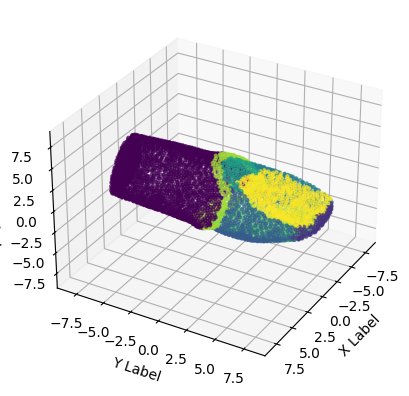

In [16]:
''' 
matplotlib绘图  最远点采样
'''
import numpy as np
import tensorflow as tf
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 加载模型和权重

num_points = 4096

def load_obj_file(file_path):
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return np.array(vertices), np.array(faces)

def center_vertices(vertices):
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices.tolist()
    
def insert_midpoint_points(vertices, faces, minimum_vertices_number=5000):
    if len(vertices) >= minimum_vertices_number:
        print('原始点云的点数足够多')
        return vertices, faces

    else:
        temp = 0
        while len(vertices) < minimum_vertices_number:
            edge_to_midpoint = {}
            new_points = []
            new_faces = []
            vertex_offset = len(vertices)
    
            for face in faces:
                # Compute midpoints for each edge
                midpoints = []
                for i in range(len(face)):
                    edge = tuple(sorted((face[i], face[(i + 1) % len(face)])))
                    if edge not in edge_to_midpoint:
                        midpoint = np.mean([vertices[edge[0]], vertices[edge[1]]], axis=0)
                        edge_to_midpoint[edge] = vertex_offset + len(new_points)
                        new_points.append(midpoint.tolist())
                    midpoints.append(edge_to_midpoint[edge])
                
                # Original vertices
                v0, v1, v2 = face
                # Midpoints
                m0, m1, m2 = midpoints

                # Create four new faces
                new_faces.append([v0, m0, m2])
                new_faces.append([v1, m1, m0])
                new_faces.append([v2, m2, m1])
                new_faces.append([m0, m1, m2])
    
            vertices.extend(new_points)
            faces = new_faces
            temp += 1

        print(f'使用了 {temp} 轮插值来让点云点数满足要求')
        
    return vertices, faces

def furthest_point_sampling(points, num_samples):
    """
    从给定的点中选择最远点采样。
    :param points: 输入的点集合，形状为 (N, D)，N为点的数量，D为维度（2或3）。
    :param num_samples: 需要采样的点数量。
    :return: 选中的最远点索引的集合和坐标的集合。
    """
    N, D = points.shape
    # 初始化已选择的点集合
    sampled_indices = np.zeros(num_samples, dtype=int)
    
    # 随机选择第一个点
    sampled_indices[0] = np.random.randint(0, N)
    
    # 计算第一个样本到所有点的距离
    distances = np.linalg.norm(points - points[sampled_indices[0]], axis=1)

    for i in range(1, num_samples):
        # 选择距离已选点集中最远的点
        sampled_indices[i] = np.argmax(distances)
        
        # 更新距离
        new_distances = np.linalg.norm(points - points[sampled_indices[i]], axis=1)
        distances = np.minimum(distances, new_distances)

    return sampled_indices, points[sampled_indices]



def process_point_cloud(file_path, num_samples):
    # 加载点云数据，确保 load_point_cloud_from_obj 返回正确的 vertices 和 faces
    vertices, faces = load_obj_file(file_path)
    vertices = center_vertices(vertices)

    # 判断是否需要插值
    if len(vertices) < 5000:
        vertices, faces = insert_midpoint_points(vertices, faces, minimum_vertices_number=5000)

    # 进行随机抽样
    
    sampled_indices, sampled_vertices = furthest_point_sampling(np.array(vertices), num_samples)

    return sampled_vertices, faces


# Matplotlib 3D 点云可视化函数
def plot_scatter_3d(points, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]

    # 根据标签创建颜色映射
    unique_labels = np.unique(labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

    label_to_color = {label: color for label, color in zip(unique_labels, colors)}
    
    # 为每个点分配颜色
    point_colors = np.array([label_to_color[label] for label in labels])
    
    ax.scatter(x, y, z, c=point_colors, marker='.', alpha=0.6)
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    # 调整视角
    ax.view_init(elev=30, azim=30)

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)
    
    plt.show()



# 打印元组的形状
sampled_vertices = process_point_cloud(file_path, num_samples=4096)

# 只选择第一个数组作为点云数据
vertices = sampled_vertices[0]
point_cloud_data = np.expand_dims(vertices, axis=0)  # 添加批次维度

# 确认扩展后的形状
print(point_cloud_data.shape)

# 进行预测
predictions = model.predict(point_cloud_data)

# 获取每个点的预测类别
predicted_labels = np.argmax(predictions, axis=-1).squeeze()

# 可视化预测结果
plot_scatter_3d(vertices, predicted_labels)


使用了 1 轮插值来让点云点数满足要求
1/1 [==============================] - 0s 215ms/step
Skipping pair (1, 3) as one of the subgraphs is missing.
Skipping pair (1, 4) as one of the subgraphs is missing.
Skipping pair (1, 5) as one of the subgraphs is missing.
Skipping pair (1, 6) as one of the subgraphs is missing.
Skipping pair (1, 8) as one of the subgraphs is missing.
Skipping pair (2, 3) as one of the subgraphs is missing.
Skipping pair (2, 4) as one of the subgraphs is missing.
Skipping pair (2, 5) as one of the subgraphs is missing.
Skipping pair (2, 6) as one of the subgraphs is missing.
Skipping pair (2, 8) as one of the subgraphs is missing.
Skipping pair (3, 4) as one of the subgraphs is missing.
Skipping pair (3, 5) as one of the subgraphs is missing.
Skipping pair (3, 6) as one of the subgraphs is missing.
Skipping pair (3, 7) as one of the subgraphs is missing.
Skipping pair (3, 8) as one of the subgraphs is missing.
Skipping pair (4, 5) as one of the subgraphs is missing.
Skipping pair (

IndexError: index 4097 is out of bounds for axis 0 with size 4096

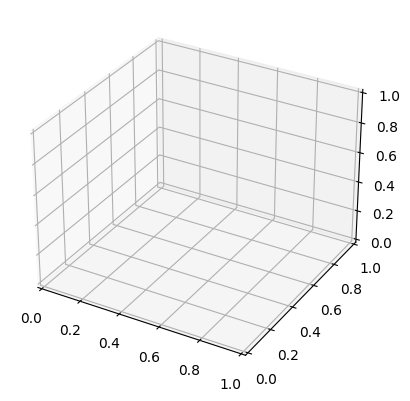

In [20]:
'''
轮廓线重建
'''
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import chardet

def detect_encoding(file_path):
    '''检测文件的encoding方式'''
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        result = chardet.detect(raw_data)
        return result['encoding']
        
def load_obj_file(file_path, encoding):
    '''读取obj文件中的点云坐标，输出是list'''
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding=encoding) as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"文件未找到: {file_path}")
    except Exception as e:
        print(f"发生错误: {e}")
    return vertices, faces

def insert_midpoint_points(vertices, faces, minimum_vertices_number=3000):
    if len(vertices) >= minimum_vertices_number:
        print('原始点云的点数足够多')
        return vertices, faces

    else:
        temp = 0
        while len(vertices) < minimum_vertices_number:
            edge_to_midpoint = {}
            new_points = []
            new_faces = []
            vertex_offset = len(vertices)
    
            for face in faces:
                # Compute midpoints for each edge
                midpoints = []
                for i in range(len(face)):
                    edge = tuple(sorted((face[i], face[(i + 1) % len(face)])))
                    if edge not in edge_to_midpoint:
                        midpoint = np.mean([vertices[edge[0]], vertices[edge[1]]], axis=0)
                        edge_to_midpoint[edge] = vertex_offset + len(new_points)
                        new_points.append(midpoint.tolist())
                    midpoints.append(edge_to_midpoint[edge])
                
                # Original vertices
                v0, v1, v2 = face
                # Midpoints
                m0, m1, m2 = midpoints

                # Create four new faces
                new_faces.append([v0, m0, m2])
                new_faces.append([v1, m1, m0])
                new_faces.append([v2, m2, m1])
                new_faces.append([m0, m1, m2])
    
            vertices.extend(new_points)
            faces = new_faces
            temp += 1

        print(f'使用了 {temp} 轮插值来让点云点数满足要求')
        
    return vertices, faces

def furthest_point_sampling(points, num_samples):
    """
    从给定的点中选择最远点采样。
    :param points: 输入的点集合，形状为 (N, D)，N为点的数量，D为维度（2或3）。
    :param num_samples: 需要采样的点数量。
    :return: 选中的最远点索引的集合和坐标的集合。
    """
    N, D = points.shape
    # 初始化已选择的点集合
    sampled_indices = np.zeros(num_samples, dtype=int)
    
    # 随机选择第一个点
    sampled_indices[0] = np.random.randint(0, N)
    
    # 计算第一个样本到所有点的距离
    distances = np.linalg.norm(points - points[sampled_indices[0]], axis=1)

    for i in range(1, num_samples):
        # 选择距离已选点集中最远的点
        sampled_indices[i] = np.argmax(distances)
        
        # 更新距离
        new_distances = np.linalg.norm(points - points[sampled_indices[i]], axis=1)
        distances = np.minimum(distances, new_distances)

    return sampled_indices, points[sampled_indices]
def generate_graph(vertices, faces):
    """
    生成点云的拓扑图。
    """
    G = nx.Graph()
    for i, vertex in enumerate(vertices):
        G.add_node(i, pos=vertex)
    for face in faces:
        for i in range(len(face)):
            G.add_edge(face[i], face[(i + 1) % len(face)])
    return G

def largest_connected_component(G, nodes):
    '''找出某标签的最大的连通子图'''
    subgraph = G.subgraph(nodes)
    largest_cc = max(nx.connected_components(subgraph), key=len)
    return subgraph.subgraph(largest_cc)

def get_max_connected_subgraphs(G, labels, target_labels):
    '''找到各标签的最大连通子图'''
    subgraphs = {}
    for label in target_labels:
        nodes = [i for i, l in enumerate(labels) if l == label]
        if nodes:
            largest_cc = largest_connected_component(G, nodes)
            subgraphs[label] = largest_cc
    return subgraphs

def find_boundary_edges(G, subgraph1, subgraph2):
    '''找到某两个标签之间的边界线'''
    boundary_edges = []
    for edge in G.edges():
        if (edge[0] in subgraph1 and edge[1] in subgraph2) or (edge[0] in subgraph2 and edge[1] in subgraph1):
            boundary_edges.append(edge)
    return boundary_edges

def get_all_boundary_edges(G, subgraphs):
    '''找到所有的边界线'''
    all_boundary_edges = {}
    for i in range(7):
        for j in range(i+1,8):
            if (i+1 in subgraphs) and (j+1 in subgraphs):  # 检查键是否存在
                all_boundary_edges[ (i+1,j+1) ] = find_boundary_edges(G, subgraphs[i+1], subgraphs[j+1])
            else:
                print(f"Skipping pair ({i+1}, {j+1}) as one of the subgraphs is missing.")
    return all_boundary_edges

def rotate_points(points, angles):
    x_angle, y_angle, z_angle = angles
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(x_angle), -np.sin(x_angle)],
        [0, np.sin(x_angle), np.cos(x_angle)]
    ])
    Ry = np.array([
        [np.cos(y_angle), 0, np.sin(y_angle)],
        [0, 1, 0],
        [-np.sin(y_angle), 0, np.cos(y_angle)]
    ])
    Rz = np.array([
        [np.cos(z_angle), -np.sin(z_angle), 0],
        [np.sin(z_angle), np.cos(z_angle), 0],
        [0, 0, 1]
    ])
    R = Rz @ Ry @ Rx
    return points @ R.T

def plot_surface_with_boundary_lines(vertices, faces, labels, boundary_edges, view_angles=(30, 30), angles=(0, 0, 0)):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    vertices = np.array(vertices)
    faces = np.array(faces)
    
    # Apply rotation
    vertices = rotate_points(vertices, angles)
    
    # 绘制不同标签区域的点云。此算法的缺点在于无法给三角标签各不相同的面染色
    # ['Ya Gen', 'Qie Duan', 'Jin Zhong', 'Yuan Zhong', 'She Zhou Mian', 'Chun Mian', 'Jian Tai', 'She Mian Wo']
    colors = ['cornflowerblue', 'cornflowerblue', 'lightgreen', 'lightgreen', 'white', 'honeydew', 'honeydew', 'honeydew']
    for i in range(8):
        part_faces = [face for face in faces if sum(labels[vertex] == i+1 for vertex in face) > 1]
        if len(part_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part_faces, color=colors[i], alpha=0.8)
    
    # 绘制边界线
    for i in range(7):
        for j in range(i+1,8):
            for edge in boundary_edges[(i+1,j+1)]:
                p1, p2 = vertices[list(edge)]
                ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='red', lw=1)
    
    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Boundary Lines')

    # 确保坐标轴刻度一致
    x, y, z = vertices.T
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)  # Adjust these values as needed

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 显示图像
    plt.show()


obj_encoding = detect_encoding(file_path)
obj_vertices, obj_faces = load_obj_file(file_path, obj_encoding)
checked_vertices, faces = insert_midpoint_points(obj_vertices, obj_faces, 5000)  # 对点数小于5000的点云做插值加密
sampled_indices, sampled_vertices = furthest_point_sampling(np.array(checked_vertices), num_samples=4096)

point_cloud_data = np.expand_dims(sampled_vertices, axis=0)  # 添加批次维度
predictions = model.predict(point_cloud_data)

# 获取每个顶点的预测标签
predicted_labels = np.argmax(predictions, axis=-1).squeeze()

G = generate_graph(checked_vertices, faces)
# 找到最大连通子图
target_labels = [1, 2, 3, 4, 5, 6, 7, 8]
subgraphs = get_max_connected_subgraphs(G, predicted_labels, target_labels)

# 找到边界线
all_boundary_edges = get_all_boundary_edges(G, subgraphs)

# 绘制点云及边界线，此处给了几组不同的姿态参数
plot_surface_with_boundary_lines(sampled_vertices, faces, predicted_labels, all_boundary_edges, view_angles=(30, 30), angles=(np.radians(-10), np.radians(0), np.radians(0)))
# plot_surface_with_boundary_lines(vertices, faces, labels, all_boundary_edges, view_angles=(30, 30), angles=(np.radians(88), np.radians(0), np.radians(160)))
